# Training Dataset Drift Detection

In this example, we will demonstrate how to detect drift from training data set using the public Airlines data set.

In [1]:
import pandas
pandas.options.display.max_rows=5 # restrict to 5 rows on display

df = pandas.read_csv("https://raw.githubusercontent.com/Devvrat53/Flight-Delay-Prediction/master/Data/flight_data.csv")
df['date'] = pandas.to_datetime(df[['year', 'month', 'day']])
df['day_index'] = (df['date'] - df['date'].min()).dt.days
df['DayOfWeek'] = df['date'].dt.day_name()
df['Month'] = df['date'].dt.month_name()
df

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,dest,air_time,distance,hour,minute,time_hour,date,day_index,DayOfWeek,Month
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,IAH,227.0,1400,5,15,1/1/2013 5:00,2013-01-01,0,Tuesday,January
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,...,IAH,227.0,1416,5,29,1/1/2013 5:00,2013-01-01,0,Tuesday,January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336774,2013,9,30,NaN,1159,NaN,NaN,1344,NaN,MQ,...,CLE,NaN,419,11,59,30-09-2013 11:00,2013-09-30,272,Monday,September
336775,2013,9,30,NaN,840,NaN,NaN,1020,NaN,MQ,...,RDU,NaN,431,8,40,30-09-2013 08:00,2013-09-30,272,Monday,September


## Data Splitting

Let's assume that we trained our model with the January through November data, and we want to run our model using the data we get each day in December. To set this up, we split the data among different data frames.

In [2]:
df_train = df[df['month'] <= 11]
df_daily = df[df['month'] > 11]

## Drift Detection

Now we want to compare our training data set to each set of daily data that we plan to feed to our model. Let's start with the categorical features.

In [3]:
from mvtk.supervisor.divergence import calc_tv_mle

columns = ['carrier', 'origin', 'dest']

df_train_transformed = df_train[columns]

grouped = df_daily.groupby('day')
batches = [g[1][columns] for g in grouped]

categorical_drift_series = []
for (day, _), batch in zip(grouped, batches):
    categorical_drift_series.append(calc_tv_mle([df_train_transformed], [batch]))

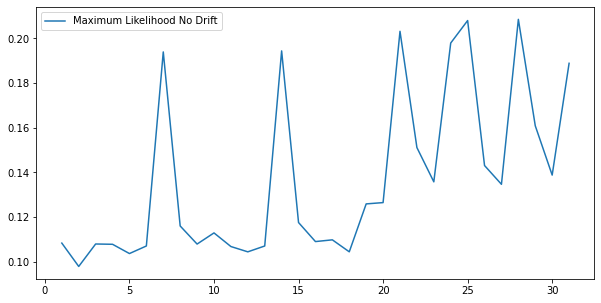

In [4]:
import matplotlib.pylab as plt

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()

days = range(1, len(categorical_drift_series) + 1)

plt.plot(days, categorical_drift_series, label='Maximum Likelihood No Drift')

plt.legend()
plt.show()

As you can see from the plot above, there is not a lot of difference between the training set and each day's set of data (floats around 0.1 to 0.2).

Let's now assume that starting on day 25, flights are increasingly routed to LAX more and more each day, with all flights going to LAX from day 29 and on. Then we will run the divergences again and plot our results.

In [5]:
df_daily = df_daily.reset_index(drop=True)

In [6]:
x = 5

for i in range(25, 32):
    df_daily.loc[(df_daily['day'] == i) & (df_daily.index % x == 0), ['dest']] = 'LAX'
    if x > 1:
        x -= 1

Below is the percentage of destination airports that are LAX per day in our updated daily data set

In [7]:
day = 1
for df_day in df_daily.groupby('day'):
    day_pct = df_day[1]['dest'].value_counts(normalize=True) * 100
    print('Day ' + str(day) + ': ' + str(round(day_pct.loc[day_pct.index == 'LAX'][0])) + '%')
    day += 1

Day 1: 5%
Day 2: 5%
Day 3: 5%
Day 4: 5%
Day 5: 5%
Day 6: 5%
Day 7: 5%
Day 8: 5%
Day 9: 5%
Day 10: 5%
Day 11: 5%
Day 12: 5%
Day 13: 5%
Day 14: 5%
Day 15: 5%
Day 16: 5%
Day 17: 5%
Day 18: 5%
Day 19: 5%
Day 20: 5%
Day 21: 5%
Day 22: 5%
Day 23: 5%
Day 24: 6%
Day 25: 24%
Day 26: 29%
Day 27: 37%
Day 28: 53%
Day 29: 100%
Day 30: 100%
Day 31: 100%


In [8]:
grouped = df_daily.groupby('day')
batches = [g[1][columns] for g in grouped]

categorical_drift_series_updated = []
for (day, _), batch in zip(grouped, batches):
    categorical_drift_series_updated.append(calc_tv_mle([df_train_transformed], [batch]))

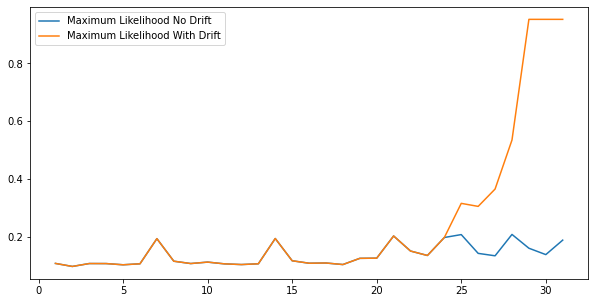

In [9]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()

plt.plot(days, categorical_drift_series, label='Maximum Likelihood No Drift')
plt.plot(days, categorical_drift_series_updated, label='Maximum Likelihood With Drift')

plt.legend()
plt.show()

As we can see above, our drift detection increases starting from 25, alerting us of the drift.

Now let's try the same exercise on the continuous features.

In [10]:
from mvtk.supervisor.divergence import calc_tv_knn

columns = ['dep_time', 'sched_dep_time', 'dep_delay', 'arr_time', 'sched_arr_time', 'arr_delay', 'air_time', 'distance', 'hour', 'minute']

df_train_transformed = df_train[columns].fillna(0)

grouped = df_daily.groupby('day')
batches = [g[1][columns].fillna(0) for g in grouped]

continuous_drift_series = []
for (day, _), batch in zip(grouped, batches):
    continuous_drift_series.append(calc_tv_knn([df_train_transformed], [batch], k=20))

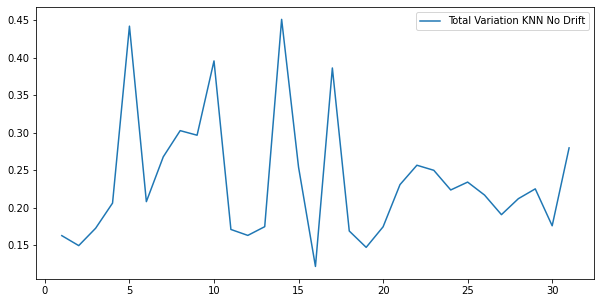

In [11]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()

plt.plot(days, continuous_drift_series, label='Total Variation KNN No Drift')

plt.legend()
plt.show()

Once again, there is not a lot of difference between the training set and each day's set of data (does not exceed 0.5).

Let's now assume that starting on day 25, flights are increasingly delayed more and more each day, with all flights delayed from day 29 and on (ignoring null values). Then we will run the divergences again and plot our results.

In [12]:
x = 5

for i in range(25, 32):
    df_daily.loc[(df_daily['day'] == i) & (df_daily.index % x == 0), ['dep_delay']] += 1000
    if x > 1:
        x -= 1

Below is the percentage of departure delays that are 500 seconds or more per day in our updated daily data set

In [13]:
day = 1
for df_day in df_daily.groupby('day'):
    day_pct = df_day[1]['dep_delay'].value_counts(normalize=True, dropna=False) * 100
    print('Day ' + str(day) + ': ' + str(round(day_pct.loc[day_pct.index >= 100].sum())) + '%')
    day += 1

Day 1: 1%
Day 2: 2%
Day 3: 2%
Day 4: 1%
Day 5: 18%
Day 6: 4%
Day 7: 1%
Day 8: 6%
Day 9: 11%
Day 10: 6%
Day 11: 1%
Day 12: 1%
Day 13: 1%
Day 14: 8%
Day 15: 4%
Day 16: 3%
Day 17: 11%
Day 18: 2%
Day 19: 3%
Day 20: 3%
Day 21: 5%
Day 22: 7%
Day 23: 10%
Day 24: 1%
Day 25: 22%
Day 26: 27%
Day 27: 35%
Day 28: 51%
Day 29: 98%
Day 30: 99%
Day 31: 98%


In [14]:
grouped = df_daily.groupby('day')
batches = [g[1][columns].fillna(0) for g in grouped]

continuous_drift_series_updated = []
for (day, _), batch in zip(grouped, batches):
    continuous_drift_series_updated.append(calc_tv_knn([df_train_transformed], [batch], k=20))

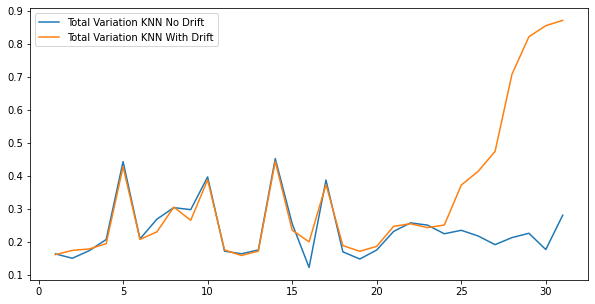

In [15]:
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()

plt.plot(days, continuous_drift_series, label='Total Variation KNN No Drift')
plt.plot(days, continuous_drift_series_updated, label='Total Variation KNN With Drift')

plt.legend()
plt.show()

As we can see above, our drift detection increases this time starting from day 28, alerting us of the drift.